# Introduction

In this notebook, I've used **CNN** to perform Image Classification on the Nail Disease dataset.<br>
Since this dataset is small, if we train a neural network to it, it won't really give us a good result.<br>
Therefore, I'm going to use the concept of **Transfer Learning** to train the model to get accurate results. Please install matplotlib, numpy, seaborn, tensorflow, opencv, and pandas. 

---

# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk(r'C:\Ken\Documents\Py\ModelTrain\NailDiseases'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\beaus\1.png
C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\beaus\2.png
C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\Bluish Nail\1.png
C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\Bluish Nail\10.png
C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\Bluish Nail\2.png
C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\Bluish Nail\3.png
C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\Bluish Nail\4.png
C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\Bluish Nail\5.png
C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\Bluish Nail\6.png
C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\Bluish Nail\7.png
C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\Bluish Nail\8.png
C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\Bluish Nail\9.png
C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\Dariers\1.png
C:\Ken\Documents\Py\ModelTrain\NailDiseases\Addition\Dariers\10.png
C:\Ken\Documents\Py\Mode

---

# Color

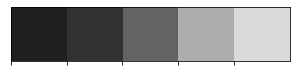

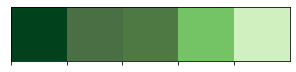

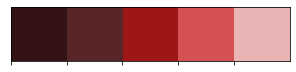

In [2]:
#Colors for graphs
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preparation

In [3]:
labels = ['Alopecia Areata', 'Clubbing', 'Muehrckes Lines',
          'Splinter Hemorrhage', 'White Nail', 'Yellow Nail']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [4]:
X_train = []
y_train = []
image_size = 224

for i in labels:
    folderPath = os.path.join(r'C:\Ken\Documents\Py\ModelTrain\NailDiseases','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X_train.append(RGB_img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(r'C:\Ken\Documents\Py\ModelTrain\NailDiseases','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X_train.append(RGB_img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 223.53it/s]


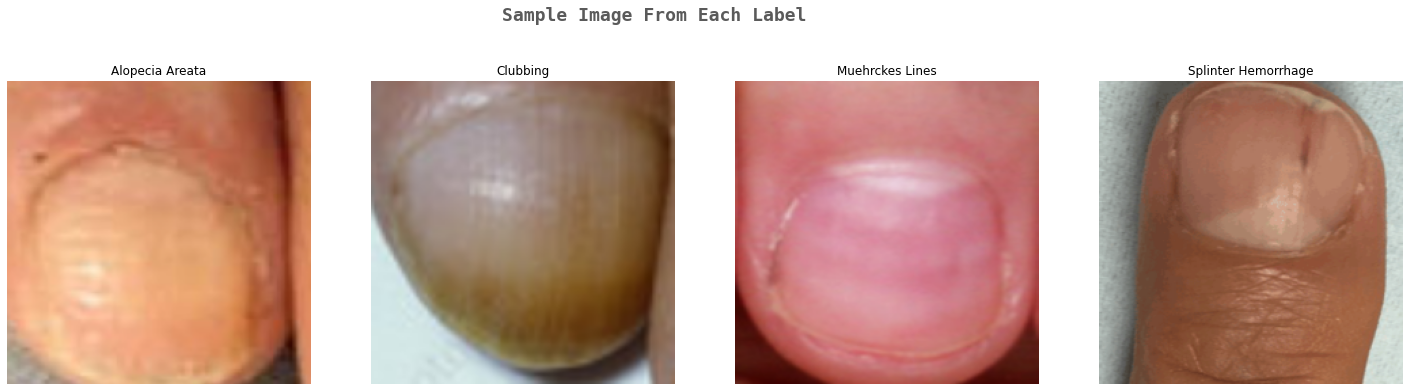

In [5]:
k=0
 
fig, ax = plt.subplots(1,4,figsize=(25,25))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
try:
    for i in labels:
        j=0
        while True :
            if y_train[j]==i:
                ax[k].imshow(X_train[j])
                ax[k].set_title(y_train[j])
                ax[k].axis('off')
                k+=1
                break
            j+=1
except IndexError as e:
    pass

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [8]:
X_train.shape

(1865, 224, 224, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case.

In [11]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [12]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [13]:
model = data_augmentation
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(6,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

We finally compile our model.

In [15]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [16]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

**Note**: The training takes *40 mins*

In [17]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs = 7,verbose=1,batch_size=22,callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/7
69/69 [==============================] - ETA: 0s - loss: 0.5447 - accuracy: 0.8185
Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to effnet.h5
69/69 [==============================] - 373s 5s/step - loss: 0.5447 - accuracy: 0.8185 - val_loss: 1.3688 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 2/7
69/69 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.9642
Epoch 2: val_accuracy improved from 0.71429 to 0.84524, saving model to effnet.h5
69/69 [==============================] - 347s 5s/step - loss: 0.1250 - accuracy: 0.9642 - val_loss: 0.6283 - val_accuracy: 0.8452 - lr: 0.0010
Epoch 3/7
69/69 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.9682
Epoch 3: val_accuracy improved from 0.84524 to 0.97024, saving model to effnet.h5
69/69 [==============================] - 324s 5s/step - loss: 0.1000 - accuracy: 0.9682 - val_loss: 0.0468 - val_accuracy: 0.9702 - lr: 0.0010
Epoch 4/7
69/69 [==============================] 

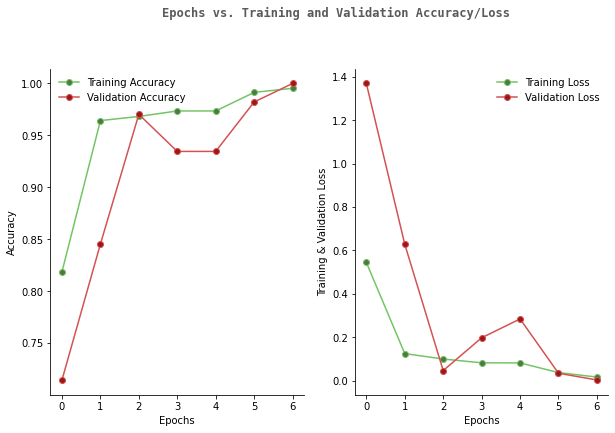

In [18]:
filterwarnings('ignore')

epochs = [i for i in range(7)]
fig, ax = plt.subplots(1,2,figsize=(10,6))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=12,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

In [19]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

6/6 [==============================] - 11s 2s/step


---

# Evaluation

In this, <br>
1 - Alopecia Areata<br>
2 - Clubbing<br>
3 - Muehrckes Lines<br>
4 - Splinter Hemorrhage<br>
5 - White Nail<br>
6 - Yellow Nail<br>

In [20]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       0.97      1.00      0.99        33
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        35
           4       1.00      0.98      0.99        43
           5       1.00      1.00      1.00        13

    accuracy                           0.99       187
   macro avg       1.00      1.00      1.00       187
weighted avg       0.99      0.99      0.99       187



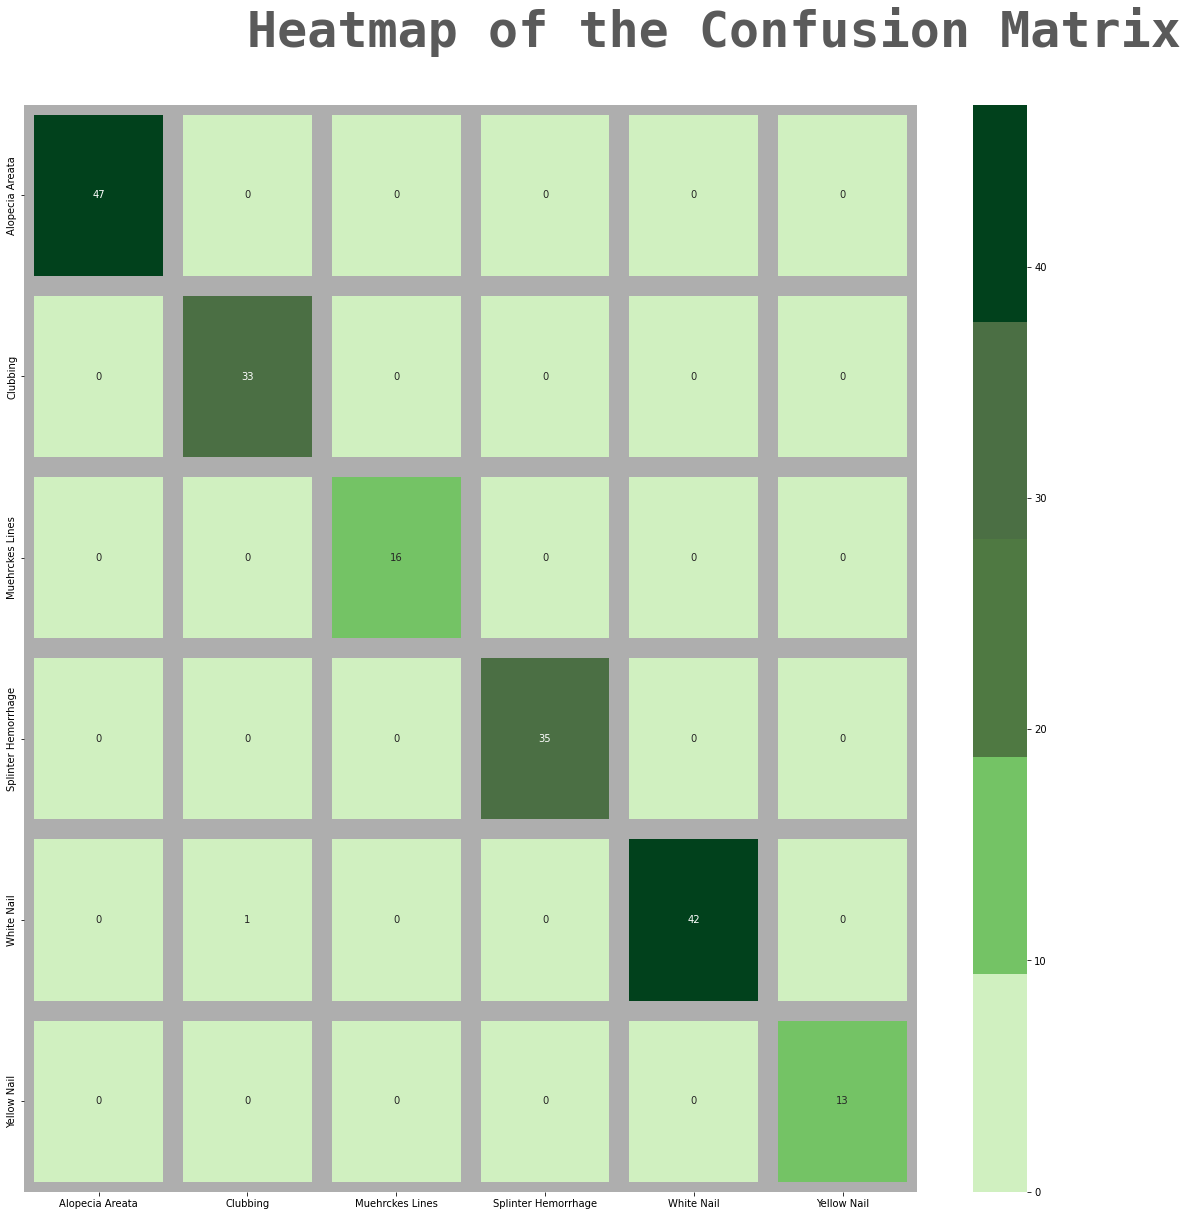

In [21]:
fig,ax=plt.subplots(1,1,figsize=(20,20))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=1,linewidths=20,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=50,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [22]:
###Widget upload and predict

---

In [24]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(224,224))
    img = img.reshape(1,224,224,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Alopecia Areata'
    elif p==1:
        p='Clubbing'
    elif p==2:
        p='Muehrckes Line'
    elif p==3:
        p='Splinter Hemorrhage'
    elif p==4:
        p='White Nail'
    else:
        p='Yellow Nail'

    if p!=0:
        print(f'The model predicts that it is a/an {p}')

This is where you can upload the image by clicking on the **Upload** button:

In [27]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

After uploading the image, you can click on the **Predict** button below to make predictions:

In [28]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

---